In [1]:
#from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os

import urllib
import requests
import json
sns.set()

In [2]:
employee = pd.read_csv('employee_retention_data.csv')

In [3]:
employee.head()

employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22

In [4]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
employee['join_date'] = pd.to_datetime(employee['join_date'])
employee['quit_date'] = pd.to_datetime(employee['quit_date'])

In [6]:
employee.tail()

employee_id  company_id              dept  seniority    salary  \
24697     549847.0           3  customer_service         16   97000.0   
24698     590087.0           4          engineer         10  160000.0   
24699     777612.0           4  customer_service         11   67000.0   
24700      97289.0          10          engineer         98  266000.0   
24701     604052.0           1         marketing         99  185000.0   

       join_date  quit_date  
24697 2015-02-18        NaT  
24698 2015-10-26        NaT  
24699 2013-09-03 2015-10-23  
24700 2011-12-13 2015-01-09  
24701 2011-07-26 2013-12-06

In [7]:
employee['company_id'].describe()

count    24702.000000
mean         3.426969
std          2.700011
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         12.000000
Name: company_id, dtype: float64

In [8]:
employee['quit_date'].max()

Timestamp('2015-12-09 00:00:00')

In [9]:
employee['join_date'].min()

Timestamp('2011-01-24 00:00:00')

In [10]:
employee['company_id'].unique().tolist()

[7, 4, 2, 9, 1, 6, 10, 5, 3, 8, 11, 12]

In [11]:
table = pd.DataFrame()
for id_num in employee['company_id'].unique().tolist():
    master= pd.DataFrame()
    master['Date'] = pd.date_range('2011-01-24','2015-12-13', freq='D')
    temp = employee[employee['company_id'] == id_num].groupby('join_date').count().reset_index()
    temp['join'] = temp['employee_id'].cumsum()
    master = pd.merge(master, temp, left_on = 'Date', right_on = ['join_date'], how ='left')

    temp = employee[employee['company_id'] == id_num].groupby('quit_date').count().reset_index()
    temp['quit'] = temp['employee_id'].cumsum()
    temp.drop(['company_id','dept','salary','join_date'], axis = 1, inplace=True)
    master = pd.merge(master, temp, left_on = 'Date', right_on = ['quit_date'], how ='left')

    master['join'] = master['join'].fillna(method = 'ffill')
    master['quit'] = master['quit'].fillna(method = 'ffill')
    master['join'] = master['join'].fillna(value = 0)
    master['quit'] = master['quit'].fillna(value = 0) 
    master['head_count'] = master['join'] - master['quit']
    master['company_id'] = id_num
    table = pd.concat([table, master[['Date',"company_id",'head_count']]], axis = 0)
    
    
    
    


In [12]:
## table with head_count data
table.head()

Date  company_id  head_count
0 2011-01-24           7         1.0
1 2011-01-25           7         1.0
2 2011-01-26           7         1.0
3 2011-01-27           7         1.0
4 2011-01-28           7         1.0

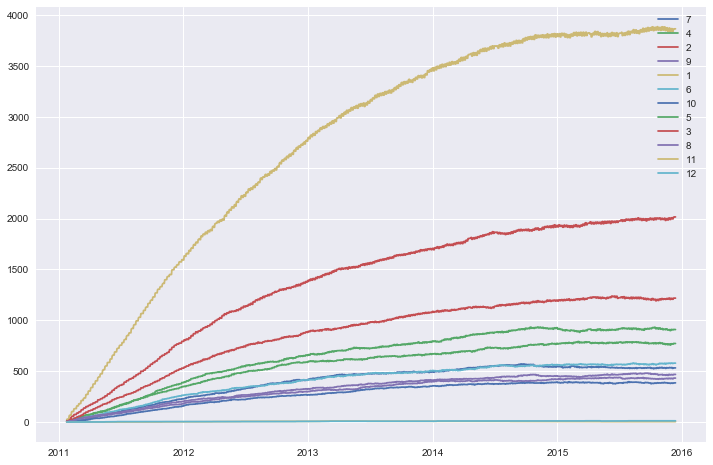

In [13]:
# company employee's growth rate is steeper at the first two years and then it starts to flat out due to the number of 
#people leaving is close to the number of people staying/joining
plt.figure(figsize=(12,8))
for name in employee['company_id'].unique().tolist():
    plt.plot(table[table['company_id']== name].Date,table[table['company_id']== name].head_count, label = name)
    plt.legend(loc =1)

In [14]:
employee['quit_date'].fillna(pd.to_datetime('2015-12-13'), inplace = True) # fill quit date to current date
employee['time_spent'] = (employee['quit_date'] - employee['join_date']).dt.days

In [15]:
# by correlation salary is highly correlated with time spent in the company, whereas seniority doesn't show much correlation
employee[['seniority','salary','time_spent']].corr()[['time_spent']]


time_spent
seniority     0.000742
salary        0.053914
time_spent    1.000000

In [16]:
low = employee['salary'].describe()['25%']
mid = employee['salary'].describe()['50%']
high = employee['salary'].describe()['75%']

def salary_range(row):
    if row['salary'] <= low:
        return 'low'
    elif row['salary'] <=mid:
        return 'mid'
    else:
        return 'high'

In [17]:
employee['salary_range'] = employee.apply(salary_range, axis = 1)

In [18]:
employee

employee_id  company_id              dept  seniority    salary  \
0          13021.0           7  customer_service         28   89000.0   
1         825355.0           7         marketing         20  183000.0   
2         927315.0           4         marketing         14  101000.0   
3         662910.0           7  customer_service         20  115000.0   
4         256971.0           2      data_science         23  276000.0   
5         509529.0           4      data_science         14  165000.0   
6          88600.0           4  customer_service         21  107000.0   
7         716309.0           2  customer_service          4   30000.0   
8         172999.0           9          engineer          7  160000.0   
9         504159.0           1             sales          7  104000.0   
10        892155.0           6  customer_service         13   72000.0   
11        904158.0           2         marketing         17  230000.0   
12        939058.0           1         marketing          1   48000.0   
13        163427.0          10         marketing         23  154000.0   
14        461248.0           2             sales         20  201000.0   
15        265226.0           1      data_science          4   80000.0   
16        932790.0           7         marketing         10   88000.0   
17         69693.0           7  customer_service          6   54000.0   
18        721600.0           2         marketing         20  193000.0   
19        982668.0           1  customer_service         14   76000.0   
20        123896.0           7          engineer         19  231000.0   
21        219944.0           6  customer_service         15   98000.0   
22        569302.0           5      data_science         14  144000.0   
23        189981.0           3         marketing         14   97000.0   
24        819445.0           2         marketing          6  151000.0   
25        467023.0           3  customer_service         15  110000.0   
26          6808.0           4      data_science         26  230000.0   
27        940786.0           3      data_science         27  223000.0   
28        888375.0           1  customer_service          5   75000.0   
29        564835.0           5  customer_service          6   71000.0   
...            ...         ...               ...        ...       ...   
24672     619765.0           1          engineer         10  207000.0   
24673     662994.0           1         marketing         10  114000.0   
24674     332323.0           1  customer_service         17  128000.0   
24675     827303.0           1  customer_service         25  140000.0   
24676      64137.0           5  customer_service         13   56000.0   
24677     670093.0           1          engineer          4   72000.0   
24678     160555.0           1         marketing         19  175000.0   
24679     612255.0           7  customer_service          6   66000.0   
24680     521551.0           3          engineer         22  273000.0   
24681     228940.0           2          engineer         27  338000.0   
24682     738266.0           3          engineer         26  239000.0   
24683     314211.0           3         marketing         15  164000.0   
24684     637395.0           1  customer_service         18  132000.0   
24685     102848.0           2  customer_service          9   87000.0   
24686     541539.0           5         marketing          5  109000.0   
24687     370156.0           3  customer_service          5   64000.0   
24688     261770.0           3          engineer          2   66000.0   
24689     711203.0          10          engineer         11  163000.0   
24690     785497.0           1             sales         24  218000.0   
24691     965573.0           6      data_science          6  159000.0   
24692       4881.0           1      data_science         28  249000.0   
24693     366356.0           9      data_science         10  173000.0   
24694     236400.0           1  customer_service          8   700

/opt/osprey/DS_VENV/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


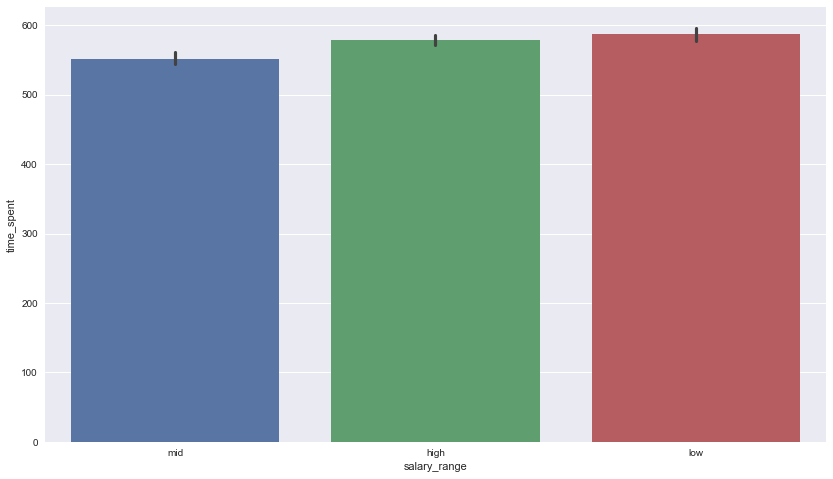

In [19]:
# explore salary range vs. time spent
plt.figure(figsize = (14,8))
sns.barplot(x= 'salary_range' , y ='time_spent', data = employee)
plt.legend()

#looks like mid salary has the lowest time spent

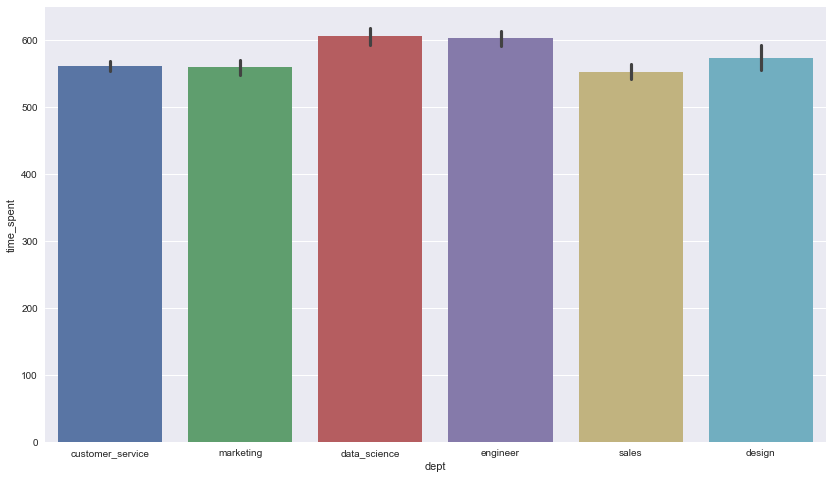

In [20]:
# explore categorial data (department)
plt.figure(figsize = (14,8))
sns.barplot(x= 'dept' , y ='time_spent', data = employee)
plt.legend()

# sales and marketing positions seem to have lower time spent as compared to data_science and engineer